In [1]:
# Based on https://towardsdatascience.com/bayesian-generalized-linear-models-with-pyro-b80bc08d7b75

In [2]:
import time         # We will time our execution often

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, MCMC, NUTS, SVI, Predictive, init_to_value

In [3]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
X = california.data
y = california.target * 100000

feature_names = california.feature_names
print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')
print(feature_names)

Data shape is (20640, 8)
Target shape is (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [4]:
california_df.assign(y=y).sample(5)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
4798   1.9928      42.0  4.077844   1.021956      1634.0  3.261477     34.03   
17771  2.3199      15.0  3.130312   0.983947      2749.0  2.595845     37.37   
9101   3.1946       5.0  5.618619   1.061061      3569.0  3.572573     34.57   
12265  1.5982      20.0  6.124016   1.226378      1000.0  1.968504     33.74   
14702  3.9745      36.0  5.951827   1.066445      1711.0  2.842193     32.79   

       Longitude         y  
4798     -118.35  125400.0  
17771    -121.84  140100.0  
9101     -117.93  132700.0  
12265    -116.88  140000.0  
14702    -117.07  170800.0

In [ ]:
# sns.pairplot(california_df)

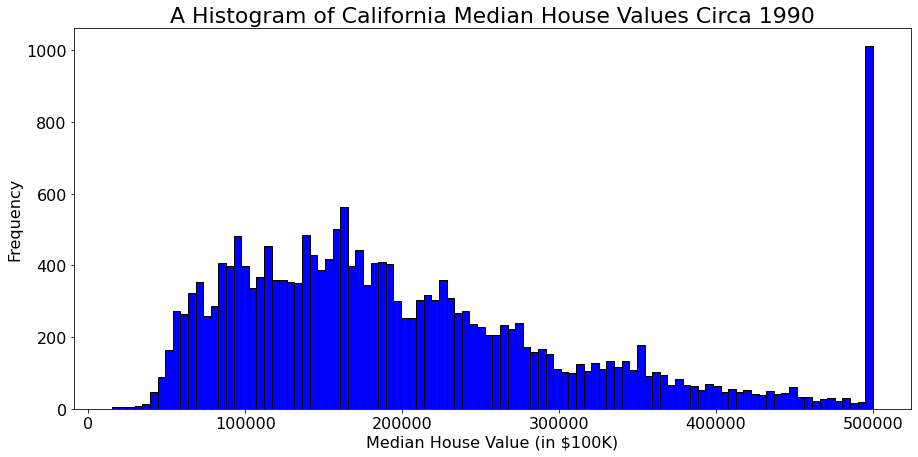

In [5]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [8]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_test[:3])
assert len(feature_names) == X.shape[1]

(16512, 8) (16512,)
(4128, 8) (4128,)
[176500.  89300. 122600.]


---
Let’s fit our linear regression

In [9]:
# start timing
start_time = time.time()

# fit linear regression
my_linear_regression = LinearRegression().fit(X_train,y_train)
y_pred = my_linear_regression.predict(X_test)

end_time = time.time()

# print point estimates of the coefficients
print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: -3731003.23
beta_MedInc: 43414.1
beta_HouseAge: 955.42
beta_AveRooms: -9751.82
beta_AveBedrms: 61118.41
beta_Population: -0.56
beta_AveOccup: -484.25
beta_Latitude: -42487.9
beta_Longitude: -43864.15


Let’s define a function to plot our predictions and the true values for the held out test set:

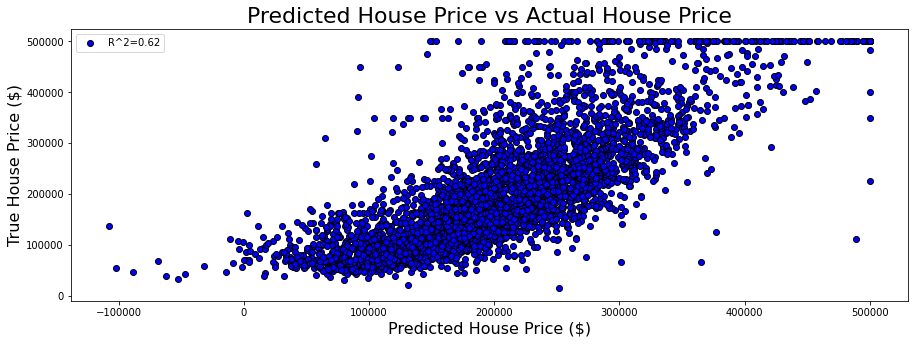

In [10]:
def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
y_censor_label = y_train.max()
plot_all_observations(y_test, y_pred, y_censor_label)

There are some observations in our data which are censored. That is, their label seems to be houses which cost $500,000+. We can define another function which plots only points which are not censored:

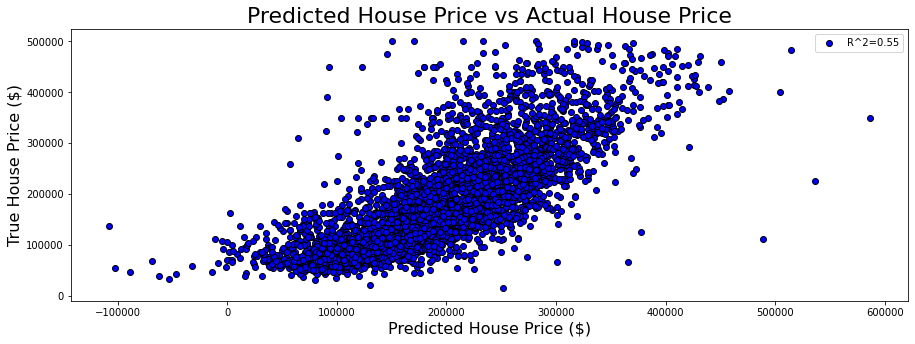

In [11]:
def plot_uncensored_observations(y_true, y_pred, y_censor_label):
    
    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
plot_uncensored_observations(y_test, y_pred, y_censor_label)

---
Reconstructing the Linear Model with Pyro


In [13]:
def model_normal(X, y, column_names):
    intercept_prior = dist.Normal(0.0, 1.0)
    
    linear_combination = numpyro.sample(f"beta_intercept", intercept_prior)
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = numpyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
        
    # Define a sigma prior for the random error
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    #with numpyro.plate("data", y.shape[0]):    
    # Assume our expected mean comes from a normal distribution with the mean which
    # depends on the linear combination, and a standard deviatin "sigma"
    outcome_dist = dist.Normal(mean, sigma)
    
    # Condition the expected mean on the observed target y
    observation = numpyro.sample("obs", outcome_dist, obs=y)

In [14]:
SAMPLE_NUMBER = 4000

my_mcmc1 = MCMC(NUTS(model_normal), 1000, SAMPLE_NUMBER, num_chains=1)

start_time = time.time()
my_mcmc1.run(random.PRNGKey(0), X_train, y_train, feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')
my_mcmc1.print_summary()

sample: 100%|██████████| 5000/5000 [01:28<00:00, 56.38it/s, 31 steps of size 1.12e-01. acc. prob=0.91] 
Inference ran for 1.5 minutes

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_AveBedrms      5.07      1.02      5.07      3.43      6.75   4488.07      1.00
    beta_AveOccup      9.30      0.99      9.31      7.70     10.88   4639.43      1.00
    beta_AveRooms     30.31      1.01     30.32     28.55     31.93   4825.98      1.00
    beta_HouseAge    164.52      0.98    164.51    162.86    166.08   3236.24      1.00
    beta_Latitude    163.11      0.99    163.10    161.58    164.79   3254.02      1.00
   beta_Longitude   -556.46      0.86   -556.45   -557.81   -554.99   2738.89      1.00
      beta_MedInc     31.63      1.01     31.63     29.96     33.25   4458.07      1.00
  beta_Population     55.14      0.07     55.14     55.02     55.26   2437.80      1.00
   beta_intercept      4.64      1.01      4.66      2.85      6.19   385

Let’s grab the individual samples from our sampler, and turn those into a dataframe (they are returned as a dictionary). We can grab the mean of each distribution as a coefficient point estimate, and then calculate a set of predictions for our data points. Then, we can compare them to our known values for house prices:

In [22]:
def samples_df_with_ordered_cols(mcmc):
    return pd.DataFrame({
        c: mcmc.get_samples()[c]
        for c in ["beta_intercept", *["beta_" + f for f in feature_names], "sigma"]
    })


In [23]:
beta_df = samples_df_with_ordered_cols(my_mcmc1)
beta_df.head()

beta_intercept  beta_MedInc  beta_HouseAge  beta_AveRooms  beta_AveBedrms  \
0        4.871446    30.751217     164.064270      29.469896        5.187046   
1        4.761006    30.480286     163.268280      29.835396        4.502887   
2        3.669830    30.813564     165.486038      30.626619        3.383420   
3        5.592018    31.891541     163.480408      31.722542        6.690153   
4        6.493373    31.625893     163.443115      28.921213        6.398688   

   beta_Population  beta_AveOccup  beta_Latitude  beta_Longitude         sigma  
0        55.137932       9.323779     163.731384     -557.853210  13439.454102  
1        55.039478       9.245958     164.224655     -556.624390  13439.659180  
2        55.098354      10.144058     163.787354     -555.959778  13455.060547  
3        55.087673       9.614644     162.790863     -558.139038  13451.994141  
4        55.078648      10.696118     162.985428     -557.383667  13453.469727

In [31]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df[["beta_" + f for f in feature_names]].mean()
    intercept = beta_df["beta_intercept"].mean()
    print(intercept, coefficients.shape)

    # Find our linear combination again
    linear_combination = X.dot(coefficients) + intercept
    
    return linear_combination

In [32]:
linear_combination = predict_linear_combination(beta_df, X_test)
# Our predictions are the linear combination
y_pred = linear_combination
print(y_pred[:3])
print(y_censor_label)

4.6363316 (8,)
[137832.50679821 147078.13083739 256359.85526918]
500000.99999999994


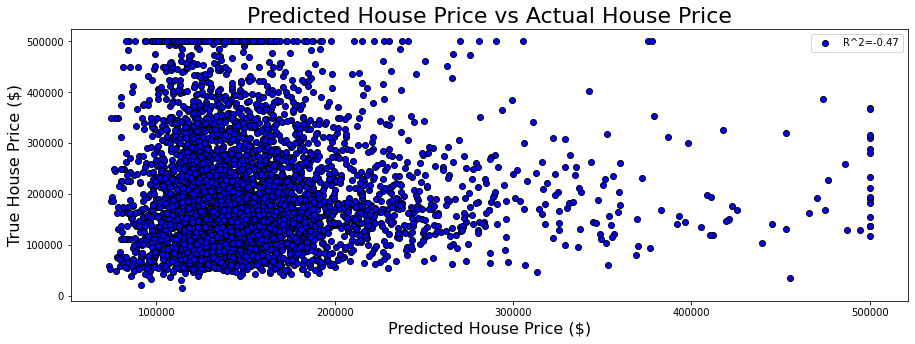

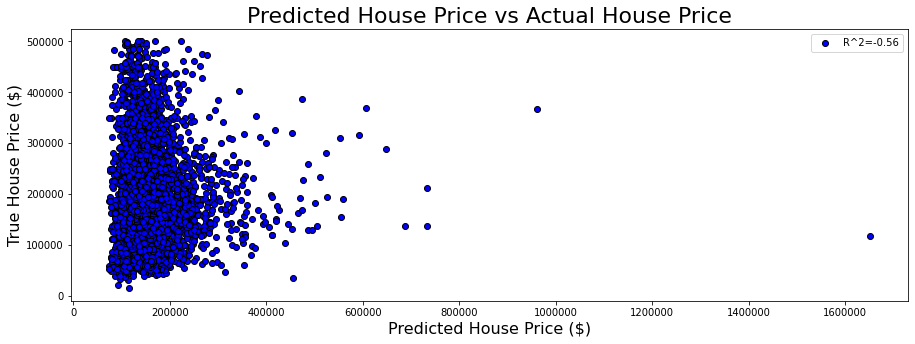

In [33]:
plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

Let’s define a function that will draw the coefficients’ distributions for us when given a coefficient dataframe:

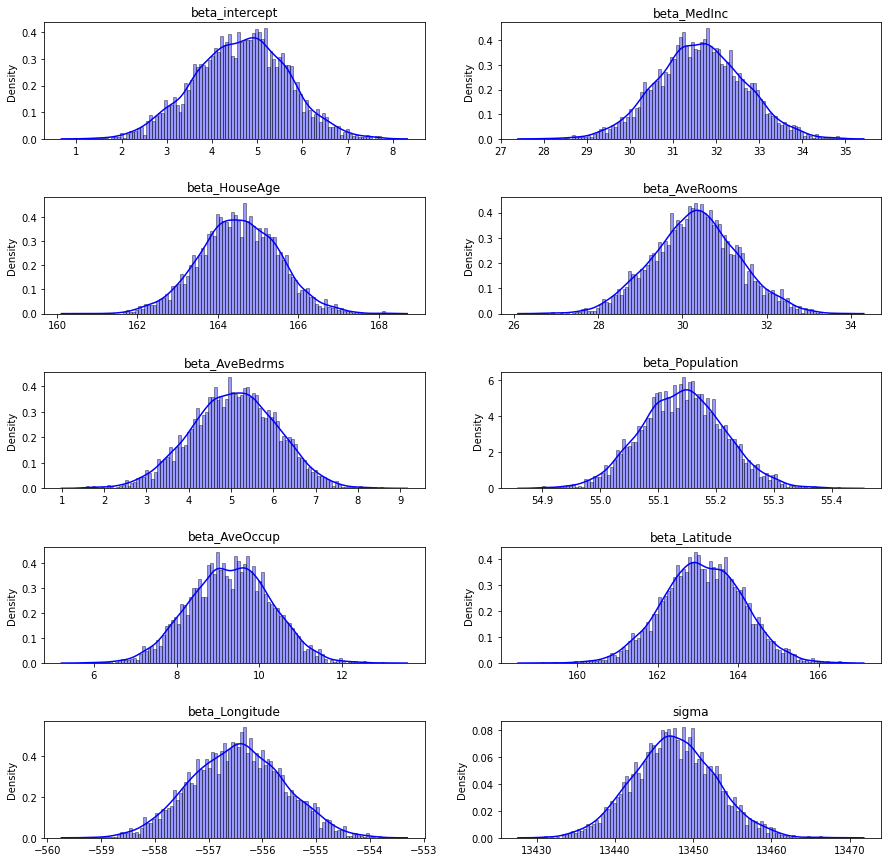

In [34]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))

    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)

y is scaled to be between 0–1 and the columns of X have been standardized:

In [36]:
from sklearn.preprocessing import StandardScaler


# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_censor_label = y_train.max()
y_train_scaled = y_train / y_censor_label

print(y_censor_label)
print(X_train_scaled[:2,:])
print(y_train_scaled[:5])

500000.99999999994
[[ 0.1326026  -1.71720349 -0.00189229  0.00573771  0.44285708 -0.01523393
  -1.15045909  1.19008296]
 [ 0.64837085  0.59336209 -0.13643205 -0.19592006 -0.56215375 -0.13331267
   0.81984793 -1.25830596]]
[0.41939916 0.70899858 0.13079974 0.51759896 0.10259979]


In [37]:
my_mcmc2 = MCMC(NUTS(model_normal), 1000, SAMPLE_NUMBER, num_chains=1)

start_time = time.time()
my_mcmc2.run(random.PRNGKey(1), X_train_scaled, y_train_scaled, feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')
my_mcmc2.print_summary()

sample: 100%|██████████| 5000/5000 [00:27<00:00, 179.77it/s, 15 steps of size 1.66e-01. acc. prob=0.91]
Inference ran for 0.47 minutes

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_AveBedrms      0.06      0.00      0.06      0.05      0.06   1640.00      1.00
    beta_AveOccup     -0.01      0.00     -0.01     -0.01     -0.00   6281.46      1.00
    beta_AveRooms     -0.05      0.00     -0.05     -0.05     -0.04   1569.45      1.00
    beta_HouseAge      0.02      0.00      0.02      0.02      0.03   4075.13      1.00
    beta_Latitude     -0.18      0.00     -0.18     -0.19     -0.18   1624.82      1.00
   beta_Longitude     -0.18      0.00     -0.18     -0.18     -0.17   1638.36      1.00
      beta_MedInc      0.16      0.00      0.16      0.16      0.17   1812.66      1.00
  beta_Population     -0.00      0.00     -0.00     -0.00      0.00   4893.95      1.00
   beta_intercept      0.41      0.00      0.41      0.41      0.42   56

We can create a function to perform the processing of the coefficients from the scaled data to the unscaled data

In [ ]:
# plot_uncensored_observations(y_test, y_pred, y_censor_label)

In [49]:
def create_beta_df(beta_df, x_scaler):
    assert all([
        beta_df.columns[1:-1][i] == "beta_" + feature_names[i]
        for i in range(max(len(feature_names), len(beta_df.columns)-2))
    ])
    # for each column except the intercept and the additional sigma term
    for i, col in enumerate(feature_names):
        if (col == 'beta_intercept'):
            continue

        col = 'beta_' + col
        print(col, x_scaler.mean_[i], x_scaler.scale_[i])

        # subtract the appropriate value from the intercept (review intercept final expression)
        beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]     
        
        # scale the coefficient (review each coefficient final expression)
        beta_df[col] /= x_scaler.scale_[i]

    return beta_df

In [51]:
#beta2_df = pd.DataFrame(my_mcmc2.get_samples())
beta2_df = samples_df_with_ordered_cols(my_mcmc2)
beta2_df = create_beta_df(beta2_df, my_x_scaler)

beta2_df *= y_censor_label   # multiply everything by y_max outside the function for reasons that will
                             # become clear later

beta_MedInc 3.862310144137618 1.8890267260379054
beta_HouseAge 28.55268895348837 12.55103959830466
beta_AveRooms 5.424847000608895 2.5131908782705152
beta_AveBedrms 1.096197332821247 0.4770572823039724
beta_Population 1424.3885053294573 1121.380948218869
beta_AveOccup 3.0212380464382247 6.389783969423313
beta_Latitude 35.63821220930232 2.1367228321112623
beta_Longitude -119.57659278100745 2.0054003506148894


In [53]:
beta2_df.head(5)

beta_intercept   beta_MedInc  beta_HouseAge  beta_AveRooms  beta_AveBedrms  \
0     -3835421.25  43264.238281     954.332520   -9912.961914    63814.664062   
1     -3742856.25  43083.800781     894.390015   -9823.975586    60643.113281   
2     -3507285.00  43829.972656    1045.157837  -10661.929688    65101.703125   
3     -3619359.50  44232.496094     960.664734  -10430.408203    62849.667969   
4     -3622988.00  43714.632812     976.911011  -10436.107422    63973.234375   

   beta_Population  beta_AveOccup  beta_Latitude  beta_Longitude         sigma  
0        -1.168723    -506.047424  -42929.406250   -44865.398438  72666.281250  
1        -1.352728    -367.591370  -43524.917969   -44306.929688  72579.601562  
2         0.516283    -634.474548  -39704.667969   -41122.765625  72814.351562  
3        -1.405313    -372.805145  -41091.253906   -42509.484375  72799.484375  
4        -1.549392    -327.310577  -41659.167969   -42702.765625  72556.085938

-3731129.2 (8,)
[[ 5.14300000e+00  9.00000000e+00  6.13989637e+00  1.09844560e+00
   1.12900000e+03  2.92487047e+00  3.79800000e+01 -1.21330000e+02]
 [ 4.00000000e+00  1.30000000e+01  4.93518519e+00  9.83796296e-01
   1.34500000e+03  3.11342593e+00  3.26800000e+01 -1.17040000e+02]
 [ 3.11250000e+00  1.10000000e+01  5.70569620e+00  1.07199367e+00
   3.26400000e+03  2.58227848e+00  3.97500000e+01 -1.21800000e+02]]
[176500.  89300. 122600.]
[214441.0338606  210160.33388839  75183.89188776]
500000.99999999994


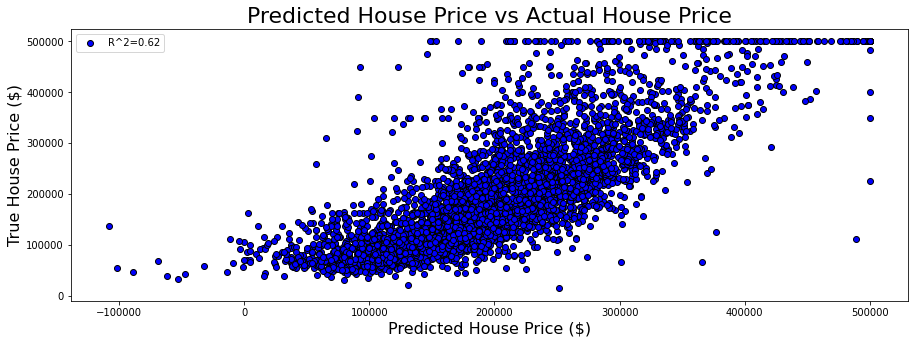

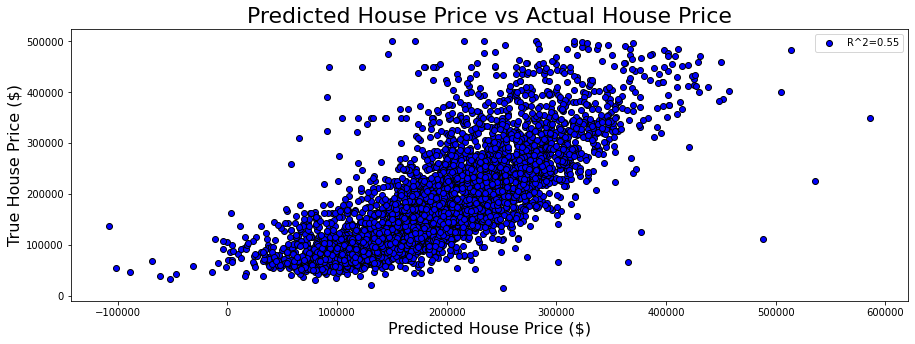

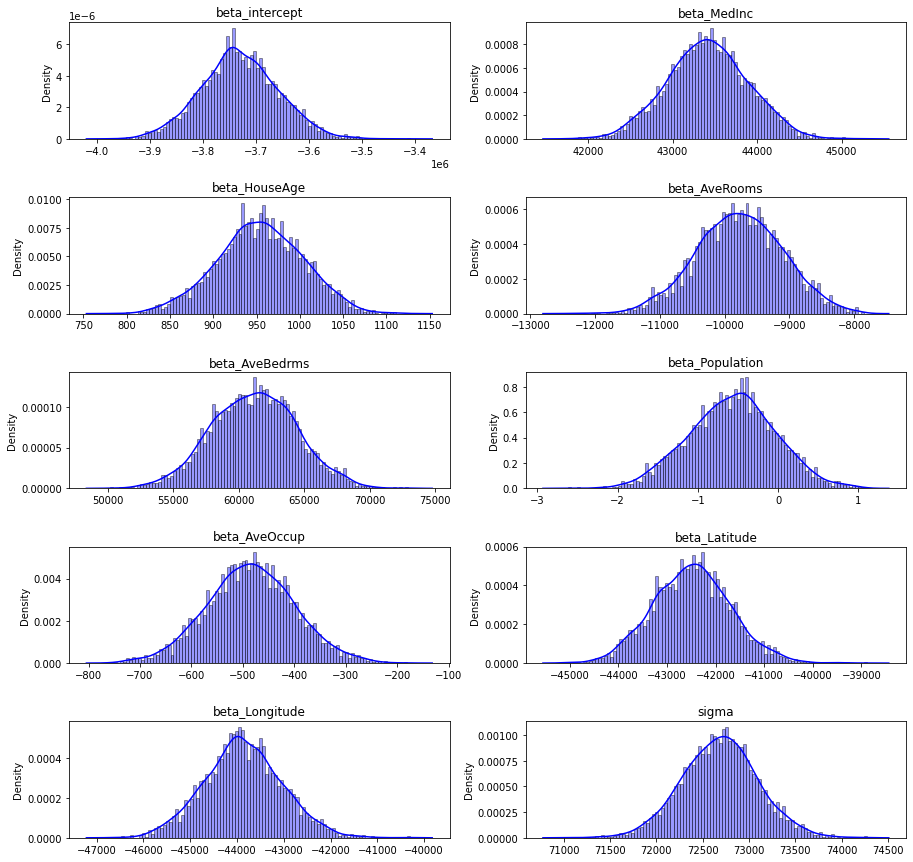

In [54]:
linear_combination = predict_linear_combination(beta2_df, X_test)

y_pred = linear_combination
print(X_test[:3,:])
print(y_test[:3])
print(y_pred[:3])
print(y_censor_label)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta2_df)

gamma

In [64]:
def model_gamma(X, y, column_names):    
    min_value = jnp.finfo(X.dtype).eps
    max_value = jnp.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = numpyro.sample(f"beta_intercept", intercept_prior)
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = numpyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    # But now our mean will be e^{linear combination}    
    mean = jnp.clip(jnp.exp(linear_combination), a_min=min_value, a_max=max_value)
    
    # We will also define a rate parameter
    rate = jnp.clip(numpyro.sample("rate", dist.HalfNormal(scale=10.0)), a_min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    # with pyro.plate("data", y.shape[0]):
        
    outcome_dist = dist.Gamma(shape, rate)
    
    observation = numpyro.sample("obs", outcome_dist, obs=y)

In [65]:
my_mcmc3 = MCMC(NUTS(model_gamma), 2000, SAMPLE_NUMBER, num_chains=1)
my_mcmc3.run(random.PRNGKey(1), X_train_scaled, y_train_scaled, feature_names)
my_mcmc3.print_summary()

sample: 100%|██████████| 6000/6000 [01:49<00:00, 54.70it/s, 31 steps of size 1.88e-01. acc. prob=0.93]

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_AveBedrms     -0.01      0.01     -0.01     -0.02     -0.00   1681.10      1.00
    beta_AveOccup     -1.14      0.02     -1.14     -1.18     -1.10   2731.48      1.00
    beta_AveRooms      0.04      0.01      0.04      0.03      0.06   1618.46      1.00
    beta_HouseAge      0.04      0.00      0.04      0.04      0.05   3988.54      1.00
    beta_Latitude     -0.65      0.01     -0.65     -0.66     -0.64   1561.67      1.00
   beta_Longitude     -0.58      0.01     -0.58     -0.60     -0.57   1526.12      1.00
      beta_MedInc      0.23      0.00      0.23      0.23      0.24   1845.69      1.00
  beta_Population      0.03      0.00      0.03      0.03      0.04   4542.70      1.00
   beta_intercept     -0.99      0.00     -0.99     -0.99     -0.98   4074.45      1.00
             rat

In [66]:
beta3_df = samples_df_with_ordered_cols(my_mcmc2)
beta3_df = create_beta_df(beta3_df, my_x_scaler)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += jnp.log(y_censor_label)

beta_MedInc 3.862310144137618 1.8890267260379054
beta_HouseAge 28.55268895348837 12.55103959830466
beta_AveRooms 5.424847000608895 2.5131908782705152
beta_AveBedrms 1.096197332821247 0.4770572823039724
beta_Population 1424.3885053294573 1121.380948218869
beta_AveOccup 3.0212380464382247 6.389783969423313
beta_Latitude 35.63821220930232 2.1367228321112623
beta_Longitude -119.57659278100745 2.0054003506148894
